![ecommerce_analytics-1224x532](ecommerce_analytics-1224x532.jpg)


As a Data Analyst at an electronics e-commerce company, Voltmart, I have been requested by a peer Machine Learning team to clean the data containing the information about orders made last year. They are planning to further use this cleaned data to build a demand forecasting model. To achieve this, they have shared their requirements regarding the desired output table format.

An analyst shared a parquet file called `"orders_data.parquet"` for me to clean and preprocess. 

I can see the dataset schema below along with the **cleaning requirements**:

## `orders_data.parquet`

| column | data type | description | cleaning requirements | 
|--------|-----------|-------------|-----------------------|
| `order_date` | `timestamp` | Date and time when the order was made | _Modify: Remove orders placed between 12am and 5am (inclusive); convert from timestamp to date_ |
| `time_of_day` | `string` | Period of the day when the order was made | _New column containing (lower bound inclusive, upper bound exclusive): "morning" for orders placed 5-12am, "afternoon" for orders placed 12-6pm, and "evening" for 6-12pm_ |
| `order_id` | `long` | Order ID | _N/A_ |
| `product` | `string` | Name of a product ordered | _Remove rows containing "TV" as the company has stopped selling this product; ensure all values are lowercase_ |
| `product_ean` | `double` | Product ID | _N/A_ |
| `category` | `string` | Broader category of a product | _Ensure all values are lowercase_ |
| `purchase_address` | `string` | Address line where the order was made ("House Street, City, State Zipcode") | _N/A_ |
| `purchase_state` | `string` | US State of the purchase address | _New column containing: the State that the purchase was ordered from_ |
| `quantity_ordered` | `long` | Number of product units ordered | _N/A_ |
| `price_each` | `double` | Price of a product unit | _N/A_ |
| `cost_price` | `double` | Cost of production per product unit | _N/A_ |
| `turnover` | `double` | Total amount paid for a product (quantity x price) | _N/A_ |
| `margin` | `double` | Profit made by selling a product (turnover - cost) | _N/A_ |

<br>

In [1]:
from pyspark.sql import (
    SparkSession,
    types,
    functions as F,
)

spark = (
    SparkSession
    .builder
    .appName('cleaning_orders_dataset_with_pyspark')
    .getOrCreate()
)

import warnings

warnings.filterwarnings('ignore')

# Set log level to ERROR
spark.sparkContext.setLogLevel("ERROR")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/11/22 21:47:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Load the orders data from a Parquet file
orders_data = spark.read.parquet('orders_data.parquet')
#Convert to Pandas DataFrame and display the first few rows
orders_data.toPandas().head(5)

,order_date,order_id,product,product_id,category,purchase_address,quantity_ordered,price_each,cost_price,turnover,margin
0,2023-01-22 21:25:00,141234,iPhone,5.638009e+12,Vêtements,"944 Walnut St, Boston, MA 02215",1,700.00,231.0000,700.00,469.0000
1,2023-01-28 14:15:00,141235,Lightning Charging Cable,5.563320e+12,Alimentation,"185 Maple St, Portland, OR 97035",1,14.95,7.4750,14.95,7.4750
2,2023-01-17 13:33:00,141236,Wired Headphones,2.113973e+12,Vêtements,"538 Adams St, San Francisco, CA 94016",2,11.99,5.9950,23.98,11.9900
3,2023-01-05 20:33:00,141237,27in FHD Monitor,3.069157e+12,Sports,"738 10th St, Los Angeles, CA 90001",1,149.99,97.4935,149.99,52.4965
4,2023-01-25 11:59:00,141238,Wired Headphones,9.692681e+12,Électronique,"387 10th St, Austin, TX 73301",1,11.99,5.9950,11.99,5.9950


### 1. Filter Orders
- Exclude rows where `order_date` is between 12:00 AM and 5:00 AM.
- Convert `order_date` to a date format.

In [3]:
# Modify: Remove orders placed between 12am and 5am (inclusive); convert from timestamp to date

from pyspark.sql.functions import to_date, hour, col, minute, date_format

# Step_1 Creating new feature - hour
orders_data1 = orders_data.withColumn('time', date_format('order_date', 'HH:mm'))\
                          .filter(~col('time').between('00:00', '05:00'))
orders_data1.limit(5).toPandas()

,order_date,order_id,product,product_id,category,purchase_address,quantity_ordered,price_each,cost_price,turnover,margin,time
0,2023-01-22 21:25:00,141234,iPhone,5.638009e+12,Vêtements,"944 Walnut St, Boston, MA 02215",1,700.00,231.0000,700.00,469.0000,21:25
1,2023-01-28 14:15:00,141235,Lightning Charging Cable,5.563320e+12,Alimentation,"185 Maple St, Portland, OR 97035",1,14.95,7.4750,14.95,7.4750,14:15
2,2023-01-17 13:33:00,141236,Wired Headphones,2.113973e+12,Vêtements,"538 Adams St, San Francisco, CA 94016",2,11.99,5.9950,23.98,11.9900,13:33
3,2023-01-05 20:33:00,141237,27in FHD Monitor,3.069157e+12,Sports,"738 10th St, Los Angeles, CA 90001",1,149.99,97.4935,149.99,52.4965,20:33
4,2023-01-25 11:59:00,141238,Wired Headphones,9.692681e+12,Électronique,"387 10th St, Austin, TX 73301",1,11.99,5.9950,11.99,5.9950,11:59


### 2. Create `time_of_day`
- Categorize orders by time:
  - Morning: 5:00 AM – 12:00 PM.
  - Afternoon: 12:00 PM – 6:00 PM.
  - Evening: 6:00 PM – 12:00 AM.

| column | data type | description | cleaning requirements | 
|--------|-----------|-------------|-----------------------|
| `time_of_day` | `string` | Period of the day when the order was made | _New column containing (lower bound inclusive, upper bound exclusive): "morning" for orders placed 5-12am, "afternoon" for orders placed 12-6pm, and "evening" for 6-12pm_ |

In [4]:
orders_data2 = orders_data1.withColumn('time_of_day', 
                                       F.when(col('time').between('05:00', '11:59'), F.lit('morning'))\
                                       .when(col('time').between('12:00', '17:59'), F.lit('afternoon'))\
                                       .when(col('time').between('18:00', '23:59'), F.lit('evening')) 
                                      )
orders_data2.limit(5).toPandas()

,order_date,order_id,product,product_id,category,purchase_address,quantity_ordered,price_each,cost_price,turnover,margin,time,time_of_day
0,2023-01-22 21:25:00,141234,iPhone,5.638009e+12,Vêtements,"944 Walnut St, Boston, MA 02215",1,700.00,231.0000,700.00,469.0000,21:25,evening
1,2023-01-28 14:15:00,141235,Lightning Charging Cable,5.563320e+12,Alimentation,"185 Maple St, Portland, OR 97035",1,14.95,7.4750,14.95,7.4750,14:15,afternoon
2,2023-01-17 13:33:00,141236,Wired Headphones,2.113973e+12,Vêtements,"538 Adams St, San Francisco, CA 94016",2,11.99,5.9950,23.98,11.9900,13:33,afternoon
3,2023-01-05 20:33:00,141237,27in FHD Monitor,3.069157e+12,Sports,"738 10th St, Los Angeles, CA 90001",1,149.99,97.4935,149.99,52.4965,20:33,evening
4,2023-01-25 11:59:00,141238,Wired Headphones,9.692681e+12,Électronique,"387 10th St, Austin, TX 73301",1,11.99,5.9950,11.99,5.9950,11:59,morning


### 3. Clean Product Data
- Remove rows where the `product` is "TV".
- Convert all product names and categories to lowercase.

| column | data type | description | cleaning requirements | 
|--------|-----------|-------------|-----------------------|
| `product` | `string` | Name of a product ordered | _Remove rows containing "TV" as the company has stopped selling this product; ensure all values are lowercase_ |

In [5]:
from pyspark.sql.functions import col, lower

orders_data3 = orders_data2.filter(~lower(col("product")).rlike("(?i)tv"))
orders_data3.limit(5).toPandas()

,order_date,order_id,product,product_id,category,purchase_address,quantity_ordered,price_each,cost_price,turnover,margin,time,time_of_day
0,2023-01-22 21:25:00,141234,iPhone,5.638009e+12,Vêtements,"944 Walnut St, Boston, MA 02215",1,700.00,231.0000,700.00,469.0000,21:25,evening
1,2023-01-28 14:15:00,141235,Lightning Charging Cable,5.563320e+12,Alimentation,"185 Maple St, Portland, OR 97035",1,14.95,7.4750,14.95,7.4750,14:15,afternoon
2,2023-01-17 13:33:00,141236,Wired Headphones,2.113973e+12,Vêtements,"538 Adams St, San Francisco, CA 94016",2,11.99,5.9950,23.98,11.9900,13:33,afternoon
3,2023-01-05 20:33:00,141237,27in FHD Monitor,3.069157e+12,Sports,"738 10th St, Los Angeles, CA 90001",1,149.99,97.4935,149.99,52.4965,20:33,evening
4,2023-01-25 11:59:00,141238,Wired Headphones,9.692681e+12,Électronique,"387 10th St, Austin, TX 73301",1,11.99,5.9950,11.99,5.9950,11:59,morning


**Let's validate that we did it correctly.**

In [6]:
orders_data3.where(col('order_id') == 141248).show()

+----------+--------+-------+----------+--------+----------------+----------------+----------+----------+--------+------+----+-----------+
|order_date|order_id|product|product_id|category|purchase_address|quantity_ordered|price_each|cost_price|turnover|margin|time|time_of_day|
+----------+--------+-------+----------+--------+----------------+----------------+----------+----------+--------+------+----+-----------+
+----------+--------+-------+----------+--------+----------------+----------------+----------+----------+--------+------+----+-----------+



| column | data type | description | cleaning requirements | 
|--------|-----------|-------------|-----------------------|
| `category` | `string` | Broader category of a product | _Ensure all values are lowercase_ |

In [7]:

orders_data4 = orders_data3.withColumn('category', lower(col('category')))
orders_data4.limit(5).toPandas()

,order_date,order_id,product,product_id,category,purchase_address,quantity_ordered,price_each,cost_price,turnover,margin,time,time_of_day
0,2023-01-22 21:25:00,141234,iPhone,5.638009e+12,vêtements,"944 Walnut St, Boston, MA 02215",1,700.00,231.0000,700.00,469.0000,21:25,evening
1,2023-01-28 14:15:00,141235,Lightning Charging Cable,5.563320e+12,alimentation,"185 Maple St, Portland, OR 97035",1,14.95,7.4750,14.95,7.4750,14:15,afternoon
2,2023-01-17 13:33:00,141236,Wired Headphones,2.113973e+12,vêtements,"538 Adams St, San Francisco, CA 94016",2,11.99,5.9950,23.98,11.9900,13:33,afternoon
3,2023-01-05 20:33:00,141237,27in FHD Monitor,3.069157e+12,sports,"738 10th St, Los Angeles, CA 90001",1,149.99,97.4935,149.99,52.4965,20:33,evening
4,2023-01-25 11:59:00,141238,Wired Headphones,9.692681e+12,électronique,"387 10th St, Austin, TX 73301",1,11.99,5.9950,11.99,5.9950,11:59,morning


### 4. Extract `purchase_state`
- Parse `purchase_address` to create a new column, `purchase_state`, containing the US state.

| column | data type | description | cleaning requirements | 
|--------|-----------|-------------|-----------------------|
| `purchase_state` | `string` | US State of the purchase address | _New column containing: the State that the purchase was ordered from_ |

In [8]:
from pyspark.sql.functions import regexp_extract

orders_data5 = orders_data4.withColumn("purchase_state", regexp_extract("purchase_address", r", (\w{2}) \d{5}", 1))
orders_data5.limit(5).toPandas()

,order_date,order_id,product,product_id,category,purchase_address,quantity_ordered,price_each,cost_price,turnover,margin,time,time_of_day,purchase_state
0,2023-01-22 21:25:00,141234,iPhone,5.638009e+12,vêtements,"944 Walnut St, Boston, MA 02215",1,700.00,231.0000,700.00,469.0000,21:25,evening,MA
1,2023-01-28 14:15:00,141235,Lightning Charging Cable,5.563320e+12,alimentation,"185 Maple St, Portland, OR 97035",1,14.95,7.4750,14.95,7.4750,14:15,afternoon,OR
2,2023-01-17 13:33:00,141236,Wired Headphones,2.113973e+12,vêtements,"538 Adams St, San Francisco, CA 94016",2,11.99,5.9950,23.98,11.9900,13:33,afternoon,CA
3,2023-01-05 20:33:00,141237,27in FHD Monitor,3.069157e+12,sports,"738 10th St, Los Angeles, CA 90001",1,149.99,97.4935,149.99,52.4965,20:33,evening,CA
4,2023-01-25 11:59:00,141238,Wired Headphones,9.692681e+12,électronique,"387 10th St, Austin, TX 73301",1,11.99,5.9950,11.99,5.9950,11:59,morning,TX


| column             | data type | description                                                    | cleaning requirements                                                                                                               |
|---------------------|-----------|----------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------|
| `product_id`       | `int64`   | Unique identifier for the product                              | _Ensure all values are positive; remove rows with invalid product IDs (negative or zero values)_                                   |
| `time`             | `string`  | Time when the order was placed in "HH:MM" format               | _Convert from string to a proper `timestamp` format for consistency and validation; ensure all values follow a valid "HH:MM" format_|
| `purchase_address` | `string`  | Address line where the order was made                         | _Extract city information into a new column `city`; ensure consistent capitalization for city names_                               |
| `category`         | `string`  | Broader category of a product                                 | _Replace non-English category names with English equivalents (e.g., "Vêtements" to "Clothing")_                                   |
| `margin`           | `float64` | Profit made by selling a product                              | _Flag rows where the margin is zero or negative for further review, as they might indicate a potential error in the data_          |

Let me know if you need help implementing these tasks in PySpark!

In [9]:
orders_data.where(col("product_id") <= 0).count()

0

**5. Validate Product ID**  
Filter the dataset to remove rows with invalid `product_id` values. Ensure `product_id` is a positive integer by identifying and excluding entries where `product_id` is less than or equal to zero. This ensures data integrity and consistency for downstream analysis.

In [10]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Sample UDF using split lambda function
extract_city = udf(lambda address: address.split(",")[1].strip(), StringType())

extract_street = udf(lambda address: address.split(",")[0].strip(), StringType())
# Apply the UDF to the 'purchase_address' column
orders_data6 = orders_data5.withColumn("city", extract_city(orders_data5["purchase_address"]))\
                           .withColumn('street_adress', extract_street(orders_data5["purchase_address"]))

# Show the updated DataFrame with the new 'city' column
orders_data6.limit(5).toPandas()


,order_date,order_id,product,product_id,category,purchase_address,quantity_ordered,price_each,cost_price,turnover,margin,time,time_of_day,purchase_state,city,street_adress
0,2023-01-22 21:25:00,141234,iPhone,5.638009e+12,vêtements,"944 Walnut St, Boston, MA 02215",1,700.00,231.0000,700.00,469.0000,21:25,evening,MA,Boston,944 Walnut St
1,2023-01-28 14:15:00,141235,Lightning Charging Cable,5.563320e+12,alimentation,"185 Maple St, Portland, OR 97035",1,14.95,7.4750,14.95,7.4750,14:15,afternoon,OR,Portland,185 Maple St
2,2023-01-17 13:33:00,141236,Wired Headphones,2.113973e+12,vêtements,"538 Adams St, San Francisco, CA 94016",2,11.99,5.9950,23.98,11.9900,13:33,afternoon,CA,San Francisco,538 Adams St
3,2023-01-05 20:33:00,141237,27in FHD Monitor,3.069157e+12,sports,"738 10th St, Los Angeles, CA 90001",1,149.99,97.4935,149.99,52.4965,20:33,evening,CA,Los Angeles,738 10th St
4,2023-01-25 11:59:00,141238,Wired Headphones,9.692681e+12,électronique,"387 10th St, Austin, TX 73301",1,11.99,5.9950,11.99,5.9950,11:59,morning,TX,Austin,387 10th St


**6. Extract City and Street Address**  
Utilize PySpark's User-Defined Functions (UDFs) to parse the `purchase_address` column and create two new columns:
- **`city`**: Extracted by splitting the `purchase_address` string on a comma (`,`) and retrieving the second segment, followed by trimming whitespace.
- **`street_address`**: Extracted by retrieving the first segment of the `purchase_address` string before the comma, followed by trimming whitespace.

**Implementation:**
- Defined two UDFs:
  - `extract_city`: Extracts the city segment from the address.
  - `extract_street`: Extracts the street address segment from the address.
- Applied these UDFs to the `purchase_address` column to generate new columns, `city` and `street_address`.

In [11]:
orders_data6.columns

['order_date',
 'order_id',
 'product',
 'product_id',
 'category',
 'purchase_address',
 'quantity_ordered',
 'price_each',
 'cost_price',
 'turnover',
 'margin',
 'time',
 'time_of_day',
 'purchase_state',
 'city',
 'street_adress']

In [12]:
orders_data7 = orders_data6.select('order_id',
                                   'order_date',
                                   'product_id',
                                   'product',
                                   'category',
                                   'quantity_ordered',
                                   'price_each',
                                   'margin',
                                   'purchase_state',
                                   'city',
                                   'street_adress',
                                   'time',
                                   'time_of_day')
orders_data7.limit(5).toPandas()

,order_id,order_date,product_id,product,category,quantity_ordered,price_each,margin,purchase_state,city,street_adress,time,time_of_day
0,141234,2023-01-22 21:25:00,5.638009e+12,iPhone,vêtements,1,700.00,469.0000,MA,Boston,944 Walnut St,21:25,evening
1,141235,2023-01-28 14:15:00,5.563320e+12,Lightning Charging Cable,alimentation,1,14.95,7.4750,OR,Portland,185 Maple St,14:15,afternoon
2,141236,2023-01-17 13:33:00,2.113973e+12,Wired Headphones,vêtements,2,11.99,11.9900,CA,San Francisco,538 Adams St,13:33,afternoon
3,141237,2023-01-05 20:33:00,3.069157e+12,27in FHD Monitor,sports,1,149.99,52.4965,CA,Los Angeles,738 10th St,20:33,evening
4,141238,2023-01-25 11:59:00,9.692681e+12,Wired Headphones,électronique,1,11.99,5.9950,TX,Austin,387 10th St,11:59,morning


In [13]:
unique_cat = orders_data7.select('category').distinct().collect()
unique_cat

[Row(category='électronique'),
 Row(category='alimentation'),
 Row(category='vêtements'),
 Row(category='sports')]

In [14]:
orders_data.where(col("margin") <= 0).count()

0

| Column            | Data Type | Description                                                    | Cleaning Requirements                                                                                                              |
|--------------------|-----------|----------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------|
| `year`            | `int`     | Year when the purchase was made                                | _Extract the year from the `purchase_date` column._                                                                               |
| `month`           | `int`     | Month when the purchase was made                               | _Extract the month from the `purchase_date` column._                                                                              |
| `day`             | `int`     | Day of the month when the purchase was made                    | _Extract the day from the `purchase_date` column._                                                                                |

In [15]:
from pyspark.sql.functions import year, month, dayofmonth

# Assuming your DataFrame has a datetime column named 'order_date'
orders_data_with_date_features = orders_data.withColumn("year", year(orders_data7["order_date"])) \
                                             .withColumn("month", month(orders_data7["order_date"])) \
                                             .withColumn("day", dayofmonth(orders_data7["order_date"]))

# Display the updated DataFrame
orders_data_with_date_features.limit(5).toPandas()

,order_date,order_id,product,product_id,category,purchase_address,quantity_ordered,price_each,cost_price,turnover,margin,year,month,day
0,2023-01-22 21:25:00,141234,iPhone,5.638009e+12,Vêtements,"944 Walnut St, Boston, MA 02215",1,700.00,231.0000,700.00,469.0000,2023,1,22
1,2023-01-28 14:15:00,141235,Lightning Charging Cable,5.563320e+12,Alimentation,"185 Maple St, Portland, OR 97035",1,14.95,7.4750,14.95,7.4750,2023,1,28
2,2023-01-17 13:33:00,141236,Wired Headphones,2.113973e+12,Vêtements,"538 Adams St, San Francisco, CA 94016",2,11.99,5.9950,23.98,11.9900,2023,1,17
3,2023-01-05 20:33:00,141237,27in FHD Monitor,3.069157e+12,Sports,"738 10th St, Los Angeles, CA 90001",1,149.99,97.4935,149.99,52.4965,2023,1,5
4,2023-01-25 11:59:00,141238,Wired Headphones,9.692681e+12,Électronique,"387 10th St, Austin, TX 73301",1,11.99,5.9950,11.99,5.9950,2023,1,25


**7. Extract Year, Month, and Day**  
Extract date components (`year`, `month`, `day`) from the `purchase_date` column to enable detailed time-based analysis of purchase patterns.

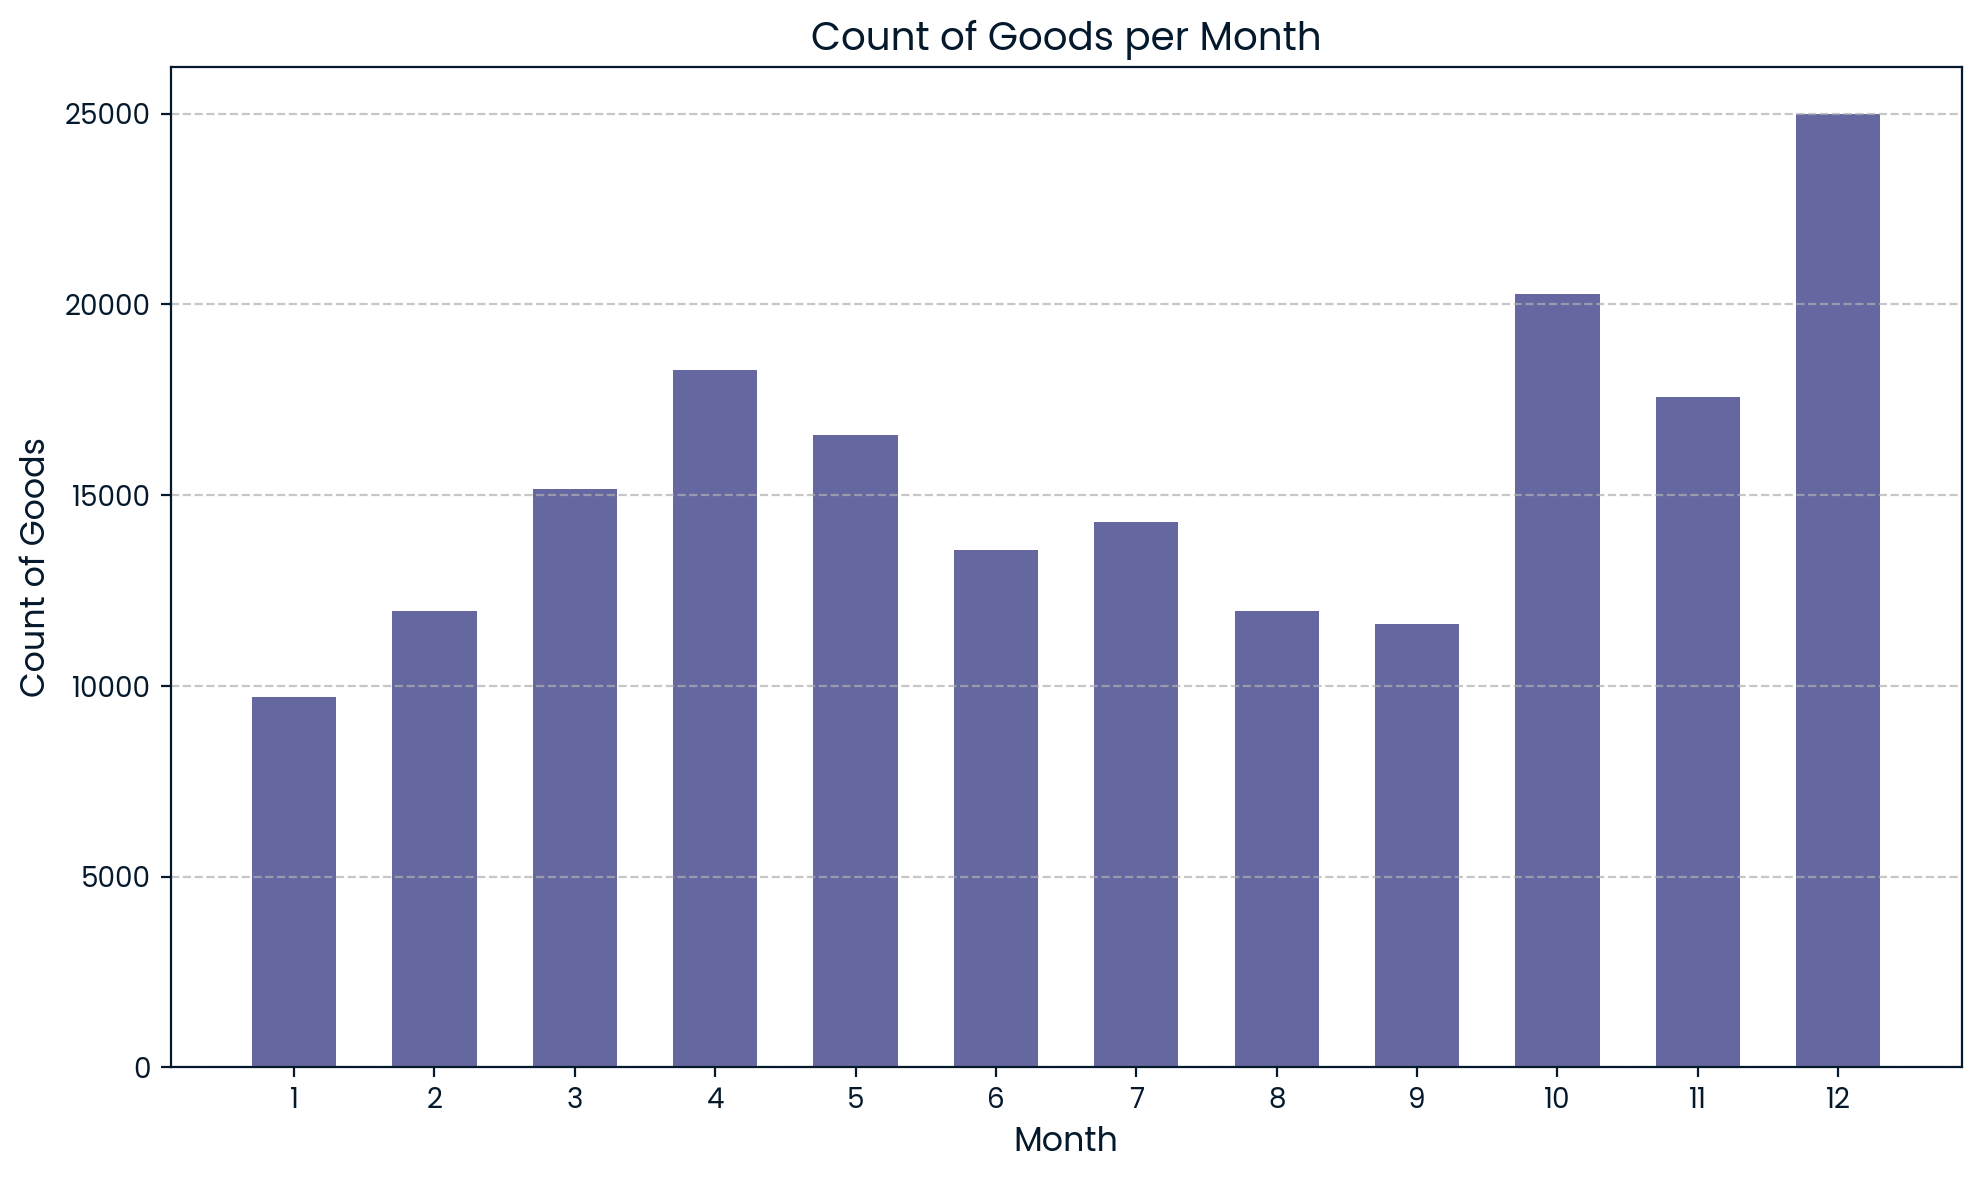

In [16]:
import matplotlib.pyplot as plt

# Assuming orders_data_with_date_features is a DataFrame with 'month' and 'product_id' columns

# Group by month and count the number of products
monthly_goods_count = orders_data_with_date_features.groupBy("month").count().orderBy("month").toPandas()

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(monthly_goods_count['month'], monthly_goods_count['count'], width=0.6)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Count of Goods", fontsize=12)
plt.title("Count of Goods per Month", fontsize=14)
plt.xticks(monthly_goods_count['month'], fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
